# Imports

In [10]:
import copy
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
from torch.m
import torchvision
from torchvision import transforms 
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

sys.path.append('../')
import utils

%matplotlib inline
plt.style.use('gadfly')

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
torch.__version__

'1.0.0'

# Get Data

In [26]:
PATH = Path('../data/hymenoptera_data/')
BATCH_SZ = 4
EPOCHS = 10
N_CLASSES = 2
LEARNING_RATE = 1e-3

In [12]:
ls {PATH}

train/ valid/


In [27]:
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

tfms = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(means, stds)]),
    'valid': transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(means, stds)])
}

In [28]:
imgs_ds = {s: ImageFolder(PATH / s, tfms[s]) for s in ['train', 'valid']}
imgs_dl = {s: DataLoader(imgs_ds[s], BATCH_SZ, shuffle=True, num_workers=4)
           for s in ['train', 'valid']}

In [29]:
len(imgs_ds['train']), len(imgs_ds['valid'])

(244, 153)

In [30]:
imgs_ds['train'].classes, imgs_ds['train'].class_to_idx

(['ants', 'bees'], {'ants': 0, 'bees': 1})

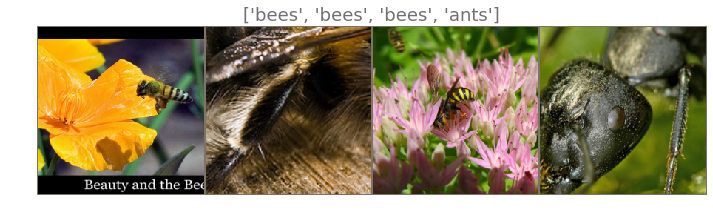

In [38]:
# Sample images
images, labels = next(iter(imgs_dl['train']))
titles = [imgs_ds['train'].classes[label] for label in labels]
utils.show_images(torchvision.utils.make_grid(images), means, stds, title=titles)

In [39]:
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
device

'cpu'

# Experiments

In [91]:
def train_model(
    model, criterion, optimizer, data_loaders, dataset_sizes, device,
    lr_scheduler, n_epochs):
    start = time.time()
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0
    history = {
        'loss': {'train': [], 'valid': []},
        'accuracy': {'train': [], 'valid': []}
    }

    print(f'{30 * "*":>50} Started training {30 * "*":<50}')
    for epoch in range(n_epochs):
        print(f'Epoch {(epoch + 1)}/{n_epochs}\n{10 * "-"}')
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0
            running_accuracy = 0

            for images, labels in data_loaders[phase]:
                images = images.to(device)
                labels = labels.to(device)
              
                # Zero grads
                optimizer.zero_grad()
                
                # Fwd pass
                with torch.set_grad_enabled(phase == 'train'):    # Set gradients on and off
                    output = model(images)
                    pred_labels = torch.argmax(output, 1)
                    
                    # Compute loss
                    loss = criterion(output, labels)

                    # Compute gradients if it's training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()
                running_accuracy += (pred_labels == labels).sum().item()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_accuracy = running_accuracy / dataset_sizes[phase]
            print(f'{phase.capitalize():<5} Loss : {epoch_loss:.4f}, '
                  f'Accuracy : {epoch_accuracy:.2%}')

            # Deep copy best model
            if phase == 'valid'and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_weights = copy.deepcopy(model.state_dict())
            
            # Update losses and accuracies
            history['loss'][phase].append(epoch_loss)
            history['accuracy'][phase].append(epoch_accuracy)
            
        print()
    time_elapsed = time.time() - start
    print(f'Training complete in : {time_elapsed // 60}m and {time_elapsed % 60:.0f}s')
    print(f'Best validation accuracy : {best_accuracy:.2%}')
    model.load_state_dict(best_model_weights)
    
    return model, history

In [106]:
model.state_dict().keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

In [75]:
torch.argmax(torch.tensor([[1, 2], [3, 1]]), dim=1)

tensor([1, 0])

In [76]:
torch.topk(torch.tensor([[1, 2], [3, 1]]), 1, dim=1)

(tensor([[2],
         [3]]), tensor([[1],
         [0]]))

In [44]:
class Net(nn.Module):
    
    def __init__(self, input_size, hidden_layers, output_size):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        hidden_layers_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.linears.extend([nn.Linear(h1, h2) for h1, h2 in hidden_layers_sizes])
        self.output = nn.Linear(hidden_layers[-1], output_size)
    
    def forward(self, x):
        for m in self.linears:
            x = F.relu(m(x))
        return F.log_softmax(x, dim=1)

In [40]:
from torch.utils.data import TensorDataset

In [41]:
ds = TensorDataset(torch.tensor([[1, 2], [3, 4]]), torch.tensor([0, 1]))

In [42]:
dl = DataLoader(ds)

In [43]:
next(iter(ds))

(tensor([1, 2]), tensor(0))

In [46]:
model = Net(10, [20, 30, 40], 10)
model

Net(
  (linears): ModuleList(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=40, bias=True)
  )
  (output): Linear(in_features=40, out_features=10, bias=True)
)

In [47]:
model.linears[0]

Linear(in_features=10, out_features=20, bias=True)

In [50]:
from collections import OrderedDict
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linears = nn.Sequential(nn.ModuleDict(
            OrderedDict([
                ('fc1', nn.Linear(10, 20)),
                ('fc2', nn.Linear(20, 30))
                ])))
        self.nonlinears = nn.Sequential(nn.ModuleDict(
            OrderedDict([
                ('fc1', nn.Linear(30, 40)),
                ('fc2', nn.Linear(40, 50))
                ])))
        
    def forward(self, x):
        x = self.linears(x)
        x = self.nonlinears(x)
        return F.log_softmax(x, dim=1)

In [52]:
model = Net()
model

Net(
  (linears): Sequential(
    (0): ModuleDict(
      (fc1): Linear(in_features=10, out_features=20, bias=True)
      (fc2): Linear(in_features=20, out_features=30, bias=True)
    )
  )
  (nonlinears): Sequential(
    (0): ModuleDict(
      (fc1): Linear(in_features=30, out_features=40, bias=True)
      (fc2): Linear(in_features=40, out_features=50, bias=True)
    )
  )
)

In [53]:
model.linears[0]

ModuleDict(
  (fc1): Linear(in_features=10, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=30, bias=True)
)

In [85]:
m.fc1.weight.data

tensor([[-0.0641, -0.3116, -0.2118,  0.3008,  0.0990, -0.1797,  0.1212, -0.1095,
          0.0450,  0.1889],
        [ 0.0606,  0.2786,  0.2290,  0.2054, -0.3069,  0.1103,  0.1582,  0.1398,
         -0.1062, -0.2183],
        [-0.1700, -0.1012,  0.0644,  0.0177, -0.1783, -0.0457,  0.1305,  0.2197,
         -0.1433, -0.2379],
        [ 0.2744,  0.0339,  0.0653, -0.0571, -0.0048,  0.1601, -0.2342, -0.2206,
          0.1729, -0.1972],
        [ 0.1807,  0.2485, -0.0336, -0.2082,  0.1041, -0.2347,  0.1674,  0.1774,
         -0.2046, -0.2678],
        [ 0.1937,  0.0118,  0.1141, -0.1931, -0.2847,  0.2274,  0.1135, -0.2434,
         -0.1870,  0.1354],
        [-0.0210,  0.1720,  0.2636, -0.2950, -0.1850, -0.2138, -0.1147,  0.1308,
         -0.0543, -0.2772],
        [-0.1491, -0.2212, -0.0825,  0.0826, -0.1827,  0.2009,  0.2337,  0.2172,
         -0.2385,  0.2888],
        [ 0.2619,  0.2015,  0.2133,  0.1956, -0.2247, -0.2796,  0.1746,  0.1334,
         -0.1133, -0.1001],
        [ 0.1842,  

In [54]:
len([param for param in model.parameters() if param.requires_grad == True])

2

In [55]:
conv_base.layer1[0].conv1.weight.data[0, 0]

tensor([[ 0.0576, -0.0951, -0.0203],
        [-0.0746, -0.7993, -0.2128],
        [ 0.0656, -0.0965, -0.0121]])

# Train

In [130]:
model = torchvision.models.resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [131]:
# Freeze conv layers
for param in model.parameters():
    param.requires_grad = False

In [132]:
# Add new classifier
model.fc = nn.Linear(512, N_CLASSES)

In [133]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [134]:
print(f'Number of trainable parameters : '
      f'{len([param for param in model.parameters() if param.requires_grad])}')
print(f'Number of non-trainable parameters : '
      f'{len([param for param in model.parameters() if not param.requires_grad])}')

Number of trainable parameters : 2
Number of non-trainable parameters : 60


In [135]:
model.layer1[0].conv1.weight.data[0, 0], \
model.layer1[0].conv1.weight.data[0, 1]

(tensor([[ 0.0576, -0.0951, -0.0203],
         [-0.0746, -0.7993, -0.2128],
         [ 0.0656, -0.0965, -0.0121]]), tensor([[-0.0070,  0.0143,  0.0006],
         [ 0.0412, -0.1613, -0.0232],
         [ 0.0033,  0.0072,  0.0717]]))

In [136]:
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [137]:
model.to(device)
best_weights = copy.deepcopy(model.state_dict())
best_acc = 0
history = {
    'loss': {'train': [], 'valid': []},
    'accuracy': {'train': [], 'valid': []}
}

for epoch in range(EPOCHS):
    print(f'Epoch : {epoch + 1}/{EPOCHS}\n{"-" * (len("epoch") + 7)}')
    for phase in ['train', 'valid']:
        running_loss = 0
        running_acc = 0
        
        if phase == 'train':
          model.train()
        else:
          model.eval()
        
        for images, labels in imgs_dl[phase]:
            images = images.to(device)
            labels = labels.to(device)
          
            with torch.set_grad_enabled(phase == 'train'):
                output = model(images)
                loss = criterion(output, labels)
                preds = torch.argmax(output, 1)
              
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item()
            running_acc += (preds == labels).sum().item()
        
        epoch_loss = running_loss / len(imgs_ds[phase])
        epoch_acc = running_acc / len(imgs_ds[phase])
        print(f'{phase.capitalize()} Loss : {epoch_loss:.4f}, '
              f'{phase.capitalize()} Accuracy : {epoch_acc:.2%}')

        # Deep copy best model
        if phase == 'valid'and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_weights = copy.deepcopy(model.state_dict())

        # Update losses and accuracies
        history['loss'][phase].append(epoch_loss)
        history['accuracy'][phase].append(epoch_acc)

    print()
time_elapsed = time.time() - start
print(f'Training complete in : {time_elapsed // 60}m and {time_elapsed % 60:.0f}s')
print(f'Best validation accuracy : {best_acc:.2%}')
model.load_state_dict(best_model_weights)

Epoch : 1/10
------------
Train Loss : 0.7033, Train Accuracy : 56.97%
Valid Loss : 0.4606, Valid Accuracy : 77.78%

Epoch : 2/10
------------
Train Loss : 0.4624, Train Accuracy : 78.69%
Valid Loss : 0.2473, Valid Accuracy : 92.16%

Epoch : 3/10
------------
Train Loss : 0.4043, Train Accuracy : 81.56%
Valid Loss : 0.2291, Valid Accuracy : 91.50%

Epoch : 4/10
------------
Train Loss : 0.4453, Train Accuracy : 80.74%
Valid Loss : 0.1823, Valid Accuracy : 94.12%

Epoch : 5/10
------------
Train Loss : 0.4147, Train Accuracy : 79.10%
Valid Loss : 0.1756, Valid Accuracy : 94.12%

Epoch : 6/10
------------
Train Loss : 0.3817, Train Accuracy : 81.97%
Valid Loss : 0.3482, Valid Accuracy : 85.62%

Epoch : 7/10
------------
Train Loss : 0.4595, Train Accuracy : 77.87%
Valid Loss : 0.2758, Valid Accuracy : 88.89%

Epoch : 8/10
------------
Train Loss : 0.3174, Train Accuracy : 85.25%
Valid Loss : 0.2221, Valid Accuracy : 92.81%

Epoch : 9/10
------------
Train Loss : 0.3738, Train Accuracy : 

NameError: name 'start' is not defined

In [138]:
model.load_state_dict(best_model_weights)

In [140]:
model.layer1[0].conv1.weight.data[0, 0], \
model.layer1[0].conv1.weight.data[0, 1]

(tensor([[ 0.0576, -0.0951, -0.0203],
         [-0.0746, -0.7993, -0.2128],
         [ 0.0656, -0.0965, -0.0121]]), tensor([[-0.0070,  0.0143,  0.0006],
         [ 0.0412, -0.1613, -0.0232],
         [ 0.0033,  0.0072,  0.0717]]))

In [142]:
model.layer1[0].conv1.weight.grad, \
model.layer1[0].conv1.weight.grad

(None, None)